# Name

Yuting Kou, Yizhou Wang, Yiming Xu, Ziyi Zhou

## Content

## Method

## Toy Example

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model
from util import hidecode
from mpl_toolkits.mplot3d import Axes3D
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# # use MSE result as params_init
# params = {'step_size':1e-3, 
#           'max_iteration':5000, 
#           'random_restarts':1}

# # fit my neural network to minimize MSE on the given data
# my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

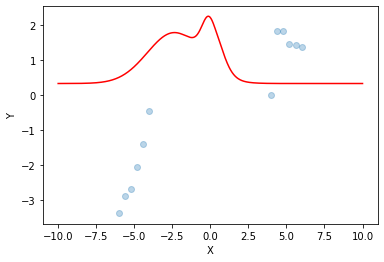

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

In [4]:
output_noise = 0.5**2
def log_likelihood(y_actual, y_pred):
    return -0.5 * np.log(2 * np.pi * output_noise) - 0.5 * np.mean(((y_actual - y_pred)**2).sum(axis = 1)) / output_noise

## Random

In [5]:
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [6]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [7]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 100.0 with step size 0.0024999820636219835
HMC 600: accept rate of 99.83333333333333 with step size 0.003999827409629551
HMC 800: accept rate of 98.625 with step size 0.00549627106306076
HMC 1000: accept rate of 98.6 with step size 0.006996271063060761
HMC 1200: accept rate of 98.16666666666667 with step size 0.008404411227470047
HMC 1400: accept rate of 98.07142857142857 with step size 0.009904411227470046
HMC 1600: accept rate of 96.625 with step size 0.0108596799901376
HMC 1800: accept rate of 96.22222222222221 with step size 0.012359679990137599
HMC 2000: accept rate of 94.5 with step size 0.013536491221972303
HMC 2200: accept rate of 94.5 with step size 0.01231362607993146
HMC 2400: accept rate of 93.5 with step size 0.01381362607993146
HMC 2600: accept rate of 91.76923076923077 with step size 0.01531362607993146
HMC 2800: accept rate of 91.07142857142857 with step size 0.014553529570902802
HMC 3000: accept

In [8]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 8.48 min


In [9]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

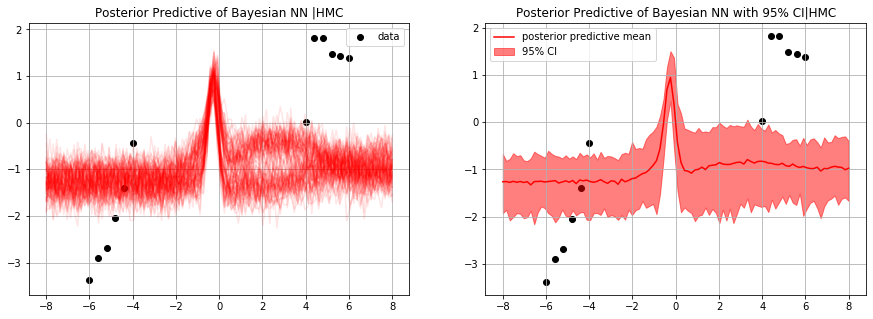

In [10]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

In [12]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_random = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_random))

The Posterior Predictive Log likelihood of the observed data is -99.5825


posterior density

In [13]:
def plot_posterior_likelihood(my_inference,name,zx_range=[-0.2,0.2], zy_range=[-0.2,0.2]):
    zx=np.linspace(zx_range[0],zx_range[1],10)
    zy=np.linspace(zy_range[0],zy_range[1],10)
    zx,zy=np.meshgrid(zx,zy)
    z=np.array([zx,zy]).reshape(2,-1).T
    level = my_inference.get_posterior_likelihood(z=z,X=x,y=y).reshape(10,10)
    post_z=my_inference.get_posterior(50)
    post_level=my_inference.get_posterior_likelihood(z=post_z,X=x,y=y)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(zx,zy,level,cmap='Reds', edgecolor='none')
    ax.scatter3D(post_z[:,0],post_z[:,1],post_level,label='chosed posterior z')
    plt.title('posterior log density ',fontsize=15)
    ax.set_xlabel('z 1')
    ax.set_ylabel('z 2')
    ax.set_zlabel('posterior log density')
    plt.legend(loc='lower left')
    ax1= fig.add_subplot(122)
    cs=ax1.contourf(zx, zy, level, levels=20, linewidths=1,cmap='Reds')
    ax1.scatter(post_z[:,0],post_z[:,1],label='chosed posterior z',s=5)
    fig.colorbar(cs, ax=ax1)
    plt.xlabel('z 1')
    plt.ylabel('z 2')
    plt.title('posterior log density ',fontsize=15)
    plt.legend()
    plt.suptitle(name, fontsize=20)

## PCA

In [15]:
my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()

In [16]:
hmc_tune_params={'step_size':5e-2,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [17]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=5)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)


In [18]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.05
HMC 400: accept rate of 100.0 with step size 0.051500000000000004
HMC 600: accept rate of 100.0 with step size 0.053000000000000005
HMC 800: accept rate of 100.0 with step size 0.05450000000000001
HMC 1000: accept rate of 99.9 with step size 0.05600000000000001
HMC 1200: accept rate of 99.91666666666667 with step size 0.057499817588135355
HMC 1400: accept rate of 99.92857142857143 with step size 0.058999817588135356
HMC 1600: accept rate of 99.9375 with step size 0.06049970397679863
HMC 1800: accept rate of 99.94444444444444 with step size 0.06199970397679863
HMC 2000: accept rate of 99.95 with step size 0.06349943951037453
HMC 2200: accept rate of 99.95454545454545 with step size 0.06499918016569026
HMC 2400: accept rate of 99.95833333333334 with step size 0.06649911021203346
HMC 2600: accept rate of 99.96153846153845 with step size 0.06798768848786536
HMC 2800: accept rate of 99.96428571428572 with step size 0.06948738431805301
HMC 30

In [19]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 18.63 min


In [20]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

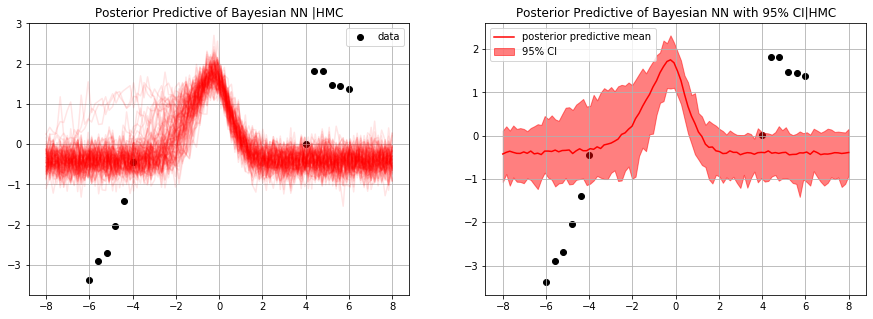

In [21]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
plt.show()

In [23]:
y_pred= my_nn.forward(P=P, w_hat=w,z=post_sample, X=x.reshape((1, -1))).reshape(-1, x.shape[-1])
log_lkhd_pca = log_likelihood(y, y_pred)
print('The Posterior Predictive Log likelihood of the observed data is {0:6.4f}'.format(log_lkhd_pca))

The Posterior Predictive Log likelihood of the observed data is -90.1768
